Copyright (c) Microsoft Corporation. All rights reserved.  
Licensed under the MIT License.

## ONNX Runtime Super Resolution with Real-ESRGAN model

In this tutorial, you will learn the end-to-end steps to obtain from a Pytorch model, convert to ONNX format and then add pre/post processing steps to the ONNX model using onnxruntime-extensions library. And apply directly in a sample mobile application if applicable.

### 0. Prerequisites

You will need to pip install the dependencies and Real-ESRGAN

```
pip install pillow numpy onnx onnxruntime onnxruntime_extensions torch torchvision
pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git
```

In [14]:
import io
import numpy as np
import onnx
import onnxruntime as ort
import shutil

###  1. Prepare ONNX Model from Pytorch Real-ESGRAN

In [15]:
import torch
from PIL import Image
from pathlib import Path
from RealESRGAN import RealESRGAN

Original `Real-ESRGAN` model: https://github.com/ai-forever/Real-ESRGAN

Download the pretrained weights for the model as per https://github.com/ai-forever/Real-ESRGAN/blob/main/weights/README.md and adjust the `weights_path` below as needed.

In [16]:
def create_onnx_model(onnx_model_path: str):

    weights_path = 'weights/RealESRGAN_x4.pth'
    if not Path(weights_path).exists():
        raise ValueError(f"{weights_path} not found. Please download the RealESRGAN_x4.pth weights as per "
                         "https://github.com/ai-forever/Real-ESRGAN/blob/main/weights/README.md")

    device = torch.device('cpu')
    esrgan_model = RealESRGAN(device, scale=4)
    esrgan_model.load_weights(weights_path, download=True)

    # We export the torch model in the RealESRGAN `model` property
    torch_model = esrgan_model.model

    # set the model to inference mode
    torch_model.eval()

    # Create random input to the model
    x = torch.randn(1, 3, 240, 240)

    # Export the model
    torch.onnx.export(torch_model,  # model being run
                      (x, ),  # model input (or a tuple for multiple inputs)
                      onnx_model_path,  # where to save the model (can be a file or file-like object)
                      export_params=True,  # store the trained parameter weights inside the model file
                      opset_version=15,  # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names=['input'],  # the model's input names
                      output_names=['output'])  # the model's output names


In [17]:
onnx_model_path = Path('RealESRGAN.onnx')
if not onnx_model_path.exists():
    print("Creating ONNX model from pytorch model...")
    create_onnx_model(str(onnx_model_path))

In [18]:
assert onnx_model_path.exists()

###  2. Add pre and post processing steps to ONNX model

In [19]:
from packaging import version

In [20]:
from onnxruntime_extensions.tools.pre_post_processing import *

In [21]:
def add_pre_post_processing(input_model_path: str, output_model_path: str):
    # we do a Resize with anti-aliasing which requires ONNX opset 18 in onnxruntime version 1.14 or later
    if version.parse(ort.__version__) < version.parse("1.14.0"):
        raise ValueError("ONNX Runtime version 1.14 or later required. Please update your onnxruntime python package.")

    onnx_opset = 18
    model = onnx.load(input_model_path)
    inputs = [create_named_value("image", onnx.TensorProto.UINT8, ["num_bytes"])]

    # infer the input sizes from the model.
    model_input_shape = model.graph.input[0].type.tensor_type.shape
    w_in = model_input_shape.dim[-1].dim_value
    h_in = model_input_shape.dim[-2].dim_value

    pipeline = PrePostProcessor(inputs, onnx_opset)
    pipeline.add_pre_processing(
        [
            ConvertImageToBGR(),  # jpg/png image to BGR in HWC layout
            ReverseAxis(axis=2, dim_value=3, name="BGR_to_RGB"),  # BGR to RGB
            Resize((h_in, w_in), layout='HWC'),
            CenterCrop(h_in, w_in),  # CenterCrop requires HWC
            ChannelsLastToChannelsFirst(),  # HWC to CHW
            ImageBytesToFloat(),  # convert to float in range 0..1
            Unsqueeze([0]),  # add batch dimensions
        ]
    )

    pipeline.add_post_processing(
        [
            Squeeze([0]),  # remove batch dimensions
            FloatToImageBytes(),  # convert back to uint8
            Transpose(perms=[1, 2, 0], name="CHW_to_HWC"),  # channels first to channels last
            ReverseAxis(axis=2, dim_value=3, name="RGB_to_BGR"),  # RGB to BGR
            ConvertBGRToImage(image_format="png", name="convert_to_png"),
        ]
    )

    new_model = pipeline.run(model)
    onnx.save_model(new_model, output_model_path)

In [22]:
output_model_path = str(onnx_model_path).replace(".onnx", "_with_pre_post_processing.onnx")
add_pre_post_processing(str(onnx_model_path), output_model_path)


**Notes**:
In this simple example we resize the input image to 240x240 which is the size the model supports.
- In the RealESRGAN python model the input image gets padded and split into tiles of size 240x240 so any input size
  can be handled and no initial resize of the input is required.
  - See https://github.com/ai-forever/Real-ESRGAN/blob/362a0316878f41dbdfbb23657b450c3353de5acf/RealESRGAN/model.py#L65-L85

- Steps as padding/tiling/batching is not currently supported in the pre-defined ONNX Runtime pre/post processing steps
  but could be added in the future.

### 3. Test output ONNX model

In [33]:
from onnxruntime_extensions import get_library_path

In [34]:
def test_onnx_model(model_path: str):
    
    so = ort.SessionOptions()
    so.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_EXTENDED

    # Note: register the custom operators for the image decode/encode pre/post processing provided by onnxruntime-extensions
    # with onnxruntime. if we do not do this we'll get an error on model load about the operators not being found.
    ortext_lib_path = get_library_path()
    so.register_custom_ops_library(ortext_lib_path)
    inference_session = ort.InferenceSession(model_path, so)
    

    test_image_path = Path.cwd() / 'testdata' / 'lr_lion.png'
    test_image_bytes = np.fromfile(test_image_path, dtype=np.uint8)
    outputs = inference_session.run(['image_out'], {'image': test_image_bytes})
    upsized_image_bytes = outputs[0]

    original_img = Image.open(io.BytesIO(test_image_bytes))
    updated_img = Image.open(io.BytesIO(upsized_image_bytes))

    # centered crop of original to match the area processed
    def _center_crop_to_square(img: Image):
        if img.height != img.width:
            target_size = img.width if img.width < img.height else img.height
            w_start = int(np.floor((img.width - target_size) / 2))
            w_end = w_start + target_size
            h_start = int(np.floor((img.height - target_size) / 2))
            h_end = h_start + target_size

            return img.crop((w_start, h_start, w_end, h_end))
        else:
            return img

    original_cropped_img = _center_crop_to_square(original_img)

    new_width, new_height = updated_img.size

    # create a side-by-side image with both.
    # resize the original to the model input size followed by the output size so the processing is more equivalent
    original_cropped_img = original_cropped_img.resize((240, 240))
    resized_orig_img = original_cropped_img.resize((new_width, new_height))

    combined = Image.new('RGB', (new_width * 2, new_height))
    combined.paste(resized_orig_img, (0, 0))
    combined.paste(updated_img, (new_width, 0))
    combined.show('Original resized vs Super Resolution resized')
    combined.save('Original resized vs Super Resolution resized.png', format='PNG')

In [32]:
test_onnx_model(output_model_path)

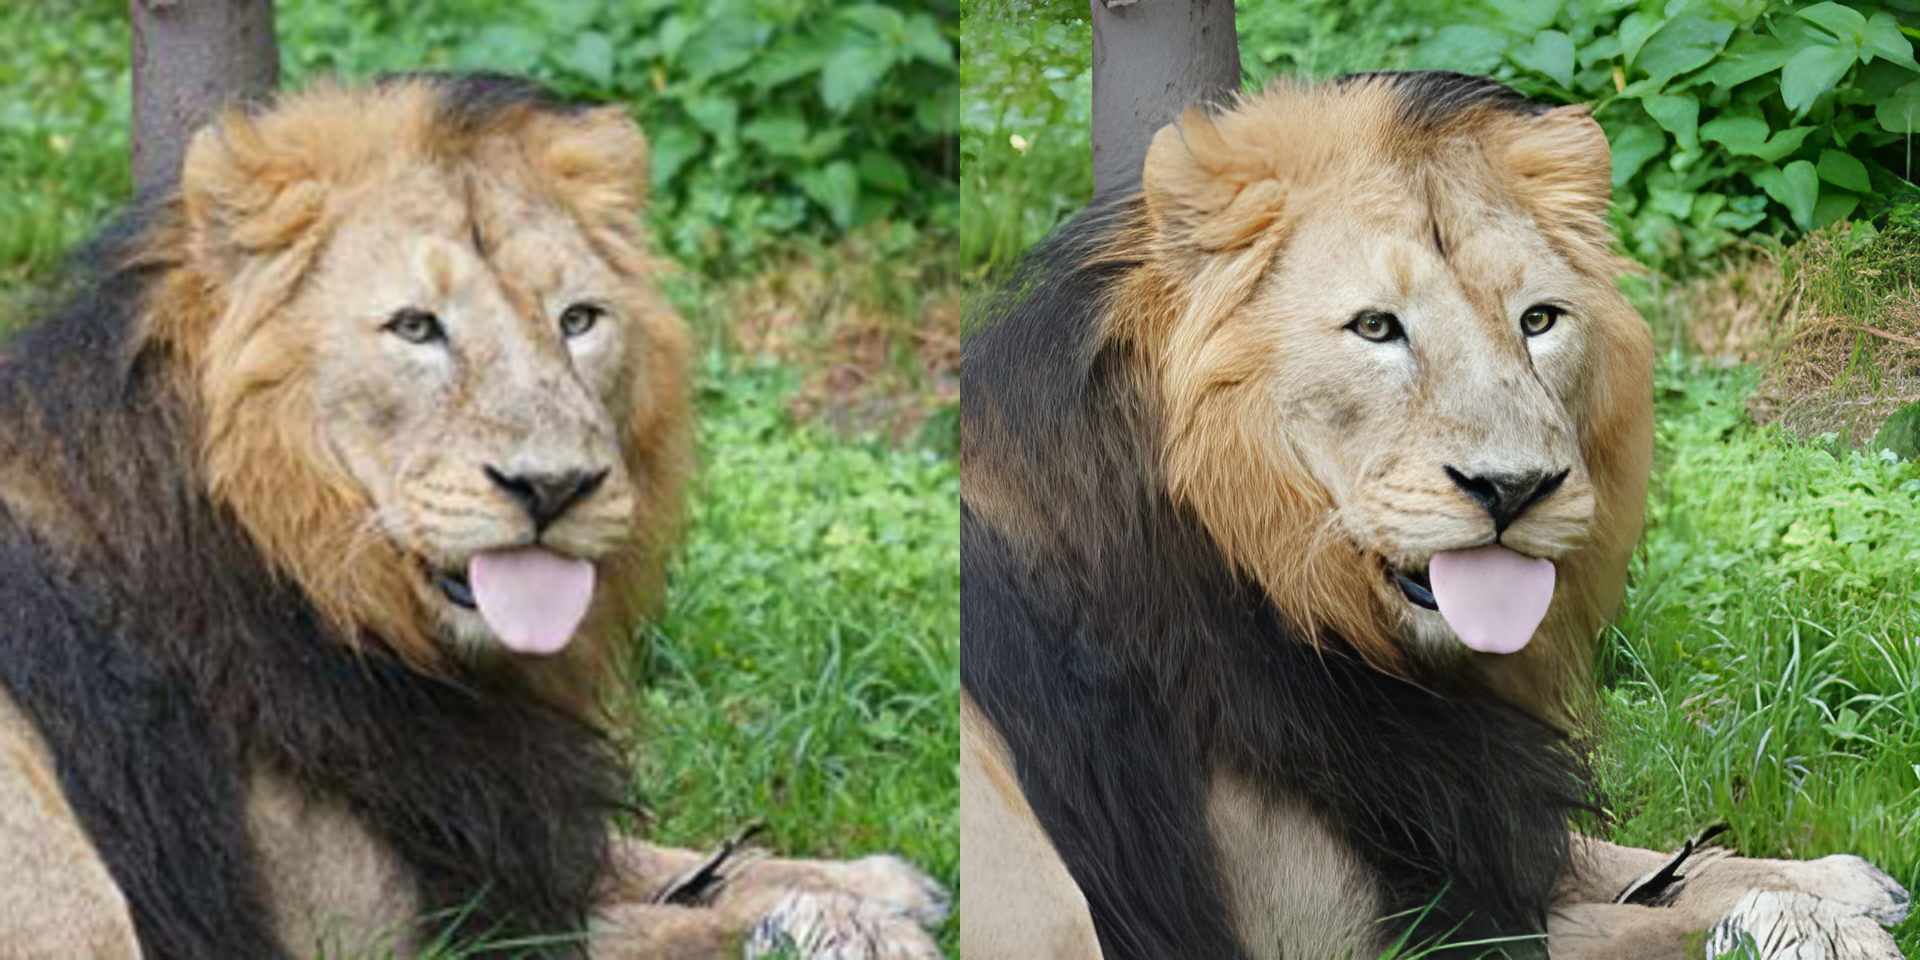

In [39]:
from IPython.display import Image

Image(filename='Original resized vs Super Resolution resized.png', width=750, height=1000)

### TODO:
Add instructions for copying the output model and point to the the super resolution sample app directory if an example app is provided.